In [1]:
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
from keras.models import Sequential
import keras.utils
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.layers import Dense, Flatten, Conv1D
from keras import backend as K

from keras.layers import Dropout
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-

# Please use the tf114 env to run this notebook

# Using InpactorDB with negative class

In [2]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

filename = '../InpactorDB/InpactorDB_non-redundant+negative.fasta.kmers'
training_data = pd.read_csv(filename)
filename=None

In [3]:
path_log_base = './logs'
# class dist|ribution
print(training_data.groupby('Label').size())

Label
0     34823
1     12031
3      1458
4      1827
8        84
9      3556
12     6180
13     3130
14     2136
16      549
17     4532
18    10396
19     3499
20    17927
dtype: int64


In [4]:
label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

training_data=None

print(label_vectors)
print(feature_vectors)

[18 18 18 ...  0  0  0]
[[2592 1965 1269 ...    4    0    0]
 [2959 2249 1811 ...    0    0    0]
 [5673 3949 3563 ...    8    4    3]
 ...
 [1451 1264 1601 ...    1    4    4]
 [2242 1036 1271 ...    7   12   28]
 [2585 1395 1287 ...    5    6    7]]


In [5]:
# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                        random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)
feature_vectors=None
label_vectors=None

from joblib import dump, load
dump(scaler, 'std_scaler_coffee.bin', compress=True)

['std_scaler_coffee.bin']

In [6]:
pca = decomposition.PCA(n_components=0.96 ,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)
dump(pca, 'std_pca_coffee.bin', compress=True)

['std_pca_coffee.bin']

In [7]:
print(len(X_trainPCAScaler[0]))
print(X_trainPCAScaler.shape)

2287
(81702, 2287)


In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def metrics(Y_validation,predictions):
    classes = len(np.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [5]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [6]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_testPCAScaler, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [7]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def InpactorFNN_Net():

    # FNN implemented by Nakano

    #Inputs
    inputs = keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(inputs)
    layers = keras.layers.Dropout(0.5)(layers)
    layers = keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    #layer 2
    layers = keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = keras.layers.Dropout(0.5)(layers)
    layers = keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    #layer 3
    layers = keras.layers.Dense(200,activation="relu",kernel_regularizer=regularizers.l1(0.0001),bias_regularizer=regularizers.l2(0.01))(layers)
    layers = keras.layers.Dropout(0.5)(layers)
    layers = keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    # layer 4
    predictions = keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

In [14]:
# arquitectura a afinar
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2287)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               457600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               600 

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [16]:
one_hot_labels_train = keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
#train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 2048, 200, "Nakano1")
Final_Results_Test(log_Dir) 

events.out.tfevents.1619021904.bioml-workstation1


OSError: Unable to open file (file signature not found)

In [ ]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

Baseline Error train: 1.18%
Baseline Error dev: 2.22%
Baseline Error test: 2.47%
Accuracy: 0.9882377420381386
F1 score: 0.9878306728391688
Recall: 0.9882377420381386
Precision: 0.9876755522335487


/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/an


 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     27905
           1       1.00      1.00      1.00      9583
           3       0.98      1.00      0.99      1204
           4       1.00      1.00      1.00      1466
           8       0.00      0.00      0.00        68
           9       1.00      1.00      1.00      2844
          12       0.98      0.99      0.99      4943
          13       0.95      1.00      0.98      2502
          14       0.99      1.00      0.99      1708
          16       0.99      0.99      0.99       432
          17       0.99      1.00      1.00      3577
          18       0.98      1.00      0.99      8258
          19       1.00      1.00      1.00      2821
          20       0.97      1.00      0.98     14391

    accuracy                           0.99     81702
   macro avg       0.92      0.92      0.92     81702
weighted avg       0.99      0.99      0.99     81702



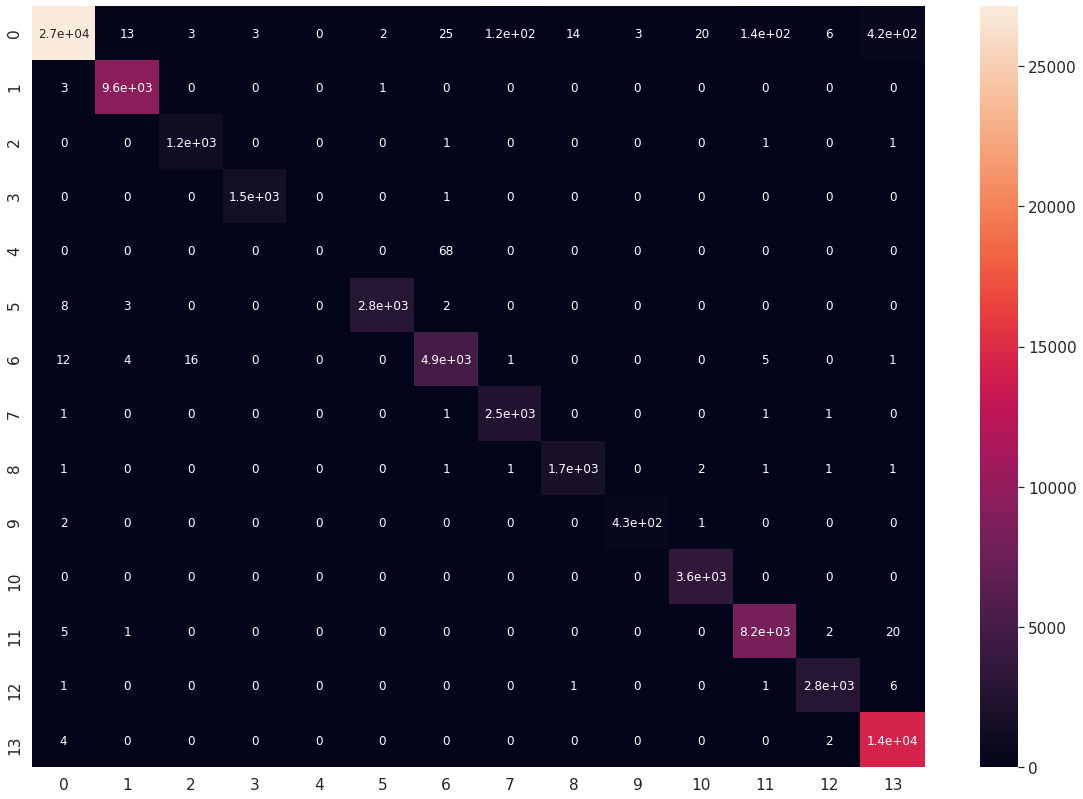

Accuracy: 0.9776755116028591
F1 score: 0.977348621694233
Recall: 0.9776755116028591
Precision: 0.9773407598441369

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      3458
           1       0.98      0.99      0.99      1244
           3       0.94      0.97      0.96       122
           4       0.99      0.99      0.99       188
           8       0.00      0.00      0.00         7
           9       0.99      0.97      0.98       369
          12       0.97      0.97      0.97       616
          13       0.94      0.97      0.96       317
          14       0.99      0.96      0.97       216
          16       1.00      0.98      0.99        51
          17       0.99      0.98      0.98       485
          18       0.98      0.99      0.98      1069
          19       0.98      0.98      0.98       330
          20       0.96      1.00      0.98      1741

    accuracy                           0.98     1

/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/an

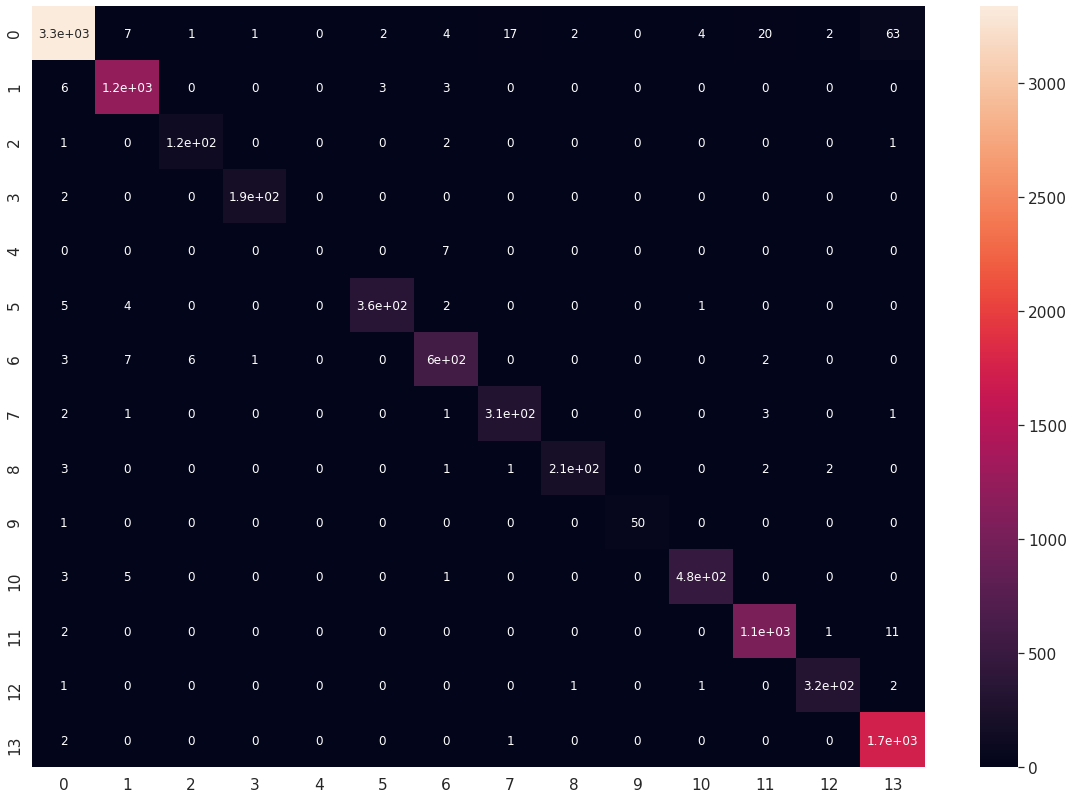

Accuracy: 0.9748359933418193
F1 score: 0.9744240598925576
Recall: 0.9748359933418193
Precision: 0.9743727724187669

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      3460
           1       0.99      0.99      0.99      1204
           3       0.98      0.98      0.98       132
           4       1.00      0.98      0.99       173
           8       0.00      0.00      0.00         9
           9       0.98      0.98      0.98       343
          12       0.96      0.96      0.96       621
          13       0.91      0.98      0.95       311
          14       0.97      0.95      0.96       212
          16       0.98      0.94      0.96        66
          17       0.99      0.97      0.98       470
          18       0.96      0.99      0.98      1069
          19       0.97      0.98      0.97       348
          20       0.96      0.99      0.98      1795

    accuracy                           0.97     

/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/an

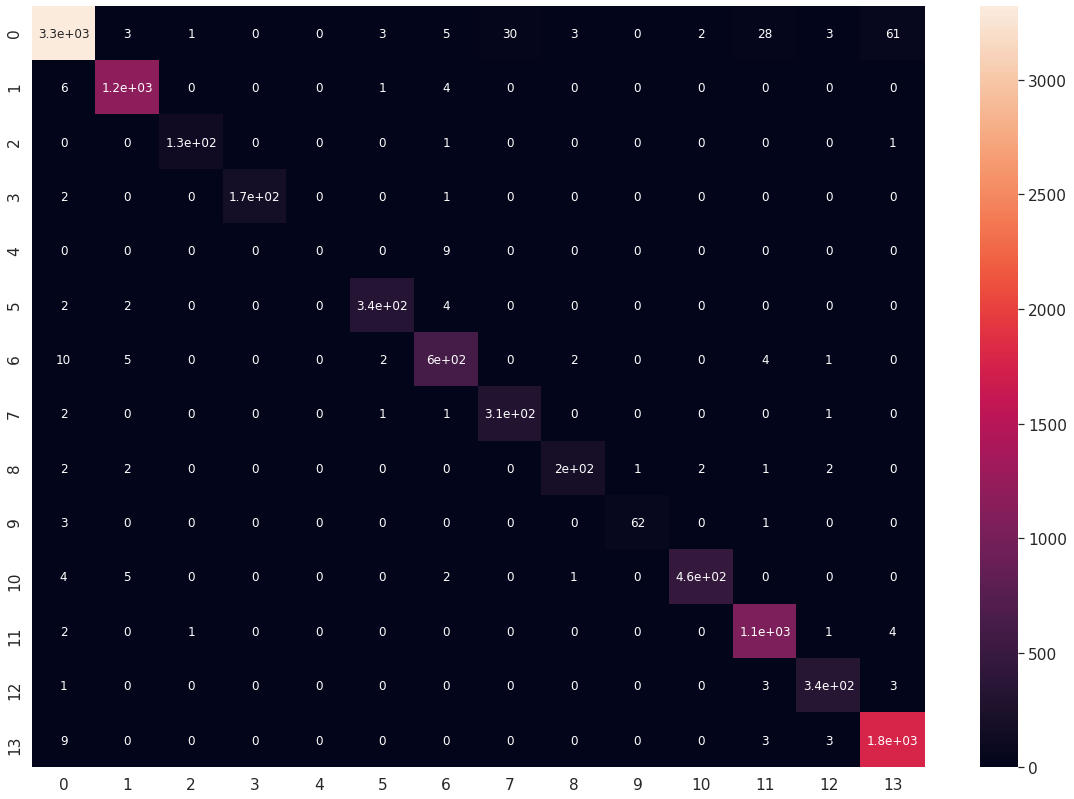

In [17]:
model = keras.models.load_model('logs/Nakano1_2021-04-21_11-18-20/saved-model-197-0.9777.hdf5', custom_objects={'f1_m':f1_m})

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

# Re-training for coffee

In [8]:
model = keras.models.load_model('logs/Nakano1_2021-04-21_11-18-20/saved-model-197-0.9777.hdf5', custom_objects={'f1_m':f1_m})

In [12]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

# cargar los datos de cafe de entrenamiento (en k-mers)
filename = '/home/bioml/Projects/PhD/OE3/database_coffea.fasta.kmers'
training_data = pd.read_csv(filename)
filename=None

label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

training_data=None

# Scaling
from joblib import dump, load
scaler = load('/home/bioml/Projects/PhD/OE3/std_scaler_coffee.bin')
feature_vectors_scaler = scaler.transform(feature_vectors)

In [13]:
# split dataset into training, validation and test
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                        random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)
feature_vectors=None
label_vectors=None

In [15]:
#PCA
pca = load('/home/bioml/Projects/PhD/OE3/std_pca_coffee.bin')
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

In [17]:
path_log_base = './logs'

one_hot_labels_train = keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 512, 200, "Coffee")
Final_Results_Test(log_Dir) 

Train on 8444 samples, validate on 1056 samples



Epoch 1/200
8444/8444 [==============================] - 0s 47us/step - loss: 0.6865 - f1_m: 0.9503 - val_loss: 0.8773 - val_f1_m: 0.9801

Epoch 2/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.6178 - f1_m: 0.9772 - val_loss: 0.7277 - val_f1_m: 0.9870
Epoch 3/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.5722 - f1_m: 0.9876 - val_loss: 0.6456 - val_f1_m: 0.9896
Epoch 4/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.5375 - f1_m: 0.9894 - val_loss: 0.5642 - val_f1_m: 0.9902
Epoch 5/200
8444/8444 [==============================] - 0s 37us/step - loss: 0.4928 - f1_m: 0.9918 - val_loss: 0.5187 - val_f1_m: 0.9905
Epoch 6/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.4560 - f1_m: 0.9936 - val_loss: 0.4757 - val_f1_m: 0.9902
Epoch 7/200
8444/8444 [==============================] - 0s 38us/step - loss: 0.4203 - f1_m: 0.9946 - val_loss: 0.4388 -

8444/8444 [==============================] - 0s 36us/step - loss: 0.3379 - f1_m: 0.9941 - val_loss: 0.3921 - val_f1_m: 0.9902
Epoch 54/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3298 - f1_m: 0.9938 - val_loss: 0.3731 - val_f1_m: 0.9902
Epoch 55/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3342 - f1_m: 0.9948 - val_loss: 0.3919 - val_f1_m: 0.9883
Epoch 56/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3369 - f1_m: 0.9954 - val_loss: 0.4003 - val_f1_m: 0.9889
Epoch 57/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3298 - f1_m: 0.9931 - val_loss: 0.3765 - val_f1_m: 0.9889
Epoch 58/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3308 - f1_m: 0.9932 - val_loss: 0.3869 - val_f1_m: 0.9892
Epoch 59/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3344 - f1_m: 0.9930 - val_loss: 0.3887 - val_f1_m: 0.9880
Epoch 60/200
8444/8444 [================

Epoch 112/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3622 - f1_m: 0.9931 - val_loss: 0.4427 - val_f1_m: 0.9880
Epoch 113/200
8444/8444 [==============================] - 0s 35us/step - loss: 0.3678 - f1_m: 0.9936 - val_loss: 0.4194 - val_f1_m: 0.9889
Epoch 114/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3607 - f1_m: 0.9935 - val_loss: 0.4137 - val_f1_m: 0.9896
Epoch 115/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3529 - f1_m: 0.9942 - val_loss: 0.4013 - val_f1_m: 0.9899
Epoch 116/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3440 - f1_m: 0.9953 - val_loss: 0.3834 - val_f1_m: 0.9902
Epoch 117/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3363 - f1_m: 0.9937 - val_loss: 0.3847 - val_f1_m: 0.9899
Epoch 118/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3317 - f1_m: 0.9942 - val_loss: 0.3856 - val_f1_m: 0.9902
Epoch 119/200
8444/8

8444/8444 [==============================] - 0s 36us/step - loss: 0.3485 - f1_m: 0.9929 - val_loss: 0.4103 - val_f1_m: 0.9870
Epoch 171/200
8444/8444 [==============================] - 0s 35us/step - loss: 0.3469 - f1_m: 0.9937 - val_loss: 0.4197 - val_f1_m: 0.9866
Epoch 172/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3435 - f1_m: 0.9948 - val_loss: 0.3995 - val_f1_m: 0.9902
Epoch 173/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3337 - f1_m: 0.9944 - val_loss: 0.3901 - val_f1_m: 0.9899
Epoch 174/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3312 - f1_m: 0.9947 - val_loss: 0.3950 - val_f1_m: 0.9886
Epoch 175/200
8444/8444 [==============================] - 0s 36us/step - loss: 0.3234 - f1_m: 0.9949 - val_loss: 0.3795 - val_f1_m: 0.9905
Epoch 176/200
8444/8444 [==============================] - 0s 35us/step - loss: 0.3281 - f1_m: 0.9935 - val_loss: 0.3926 - val_f1_m: 0.9899
Epoch 177/200
8444/8444 [=========

OSError: Unable to open file (file signature not found)

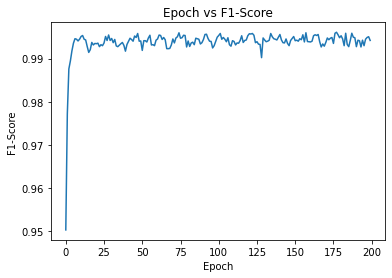


Train Accuracy 0.9960919618606567, Época:178

Train Accuracy 0.995974063873291, Época:158

Train Accuracy 0.9959664344787598, Época:75

Train Accuracy 0.9958624243736267, Época:188

Train Accuracy 0.995858371257782, Época:184

Train Accuracy 0.9958550930023193, Época:177

Train Accuracy 0.9958043098449707, Época:102

Train Accuracy 0.9958024621009827, Época:123

Train Accuracy 0.9958013892173767, Época:48

Train Accuracy 0.9957997798919678, Época:135


Validation F1-Score 0.9928314685821533, Época:32

Validation F1-Score 0.9928244948387146, Época:9

Validation F1-Score 0.9925031065940857, Época:184

Validation F1-Score 0.9924986362457275, Época:10

Validation F1-Score 0.992179811000824, Época:25

Validation F1-Score 0.992179811000824, Época:70

Validation F1-Score 0.9921722412109375, Época:26

Validation F1-Score 0.9921715259552002, Época:20

Validation F1-Score 0.9918584227561951, Época:61

Validation F1-Score 0.9918577671051025, Época:27



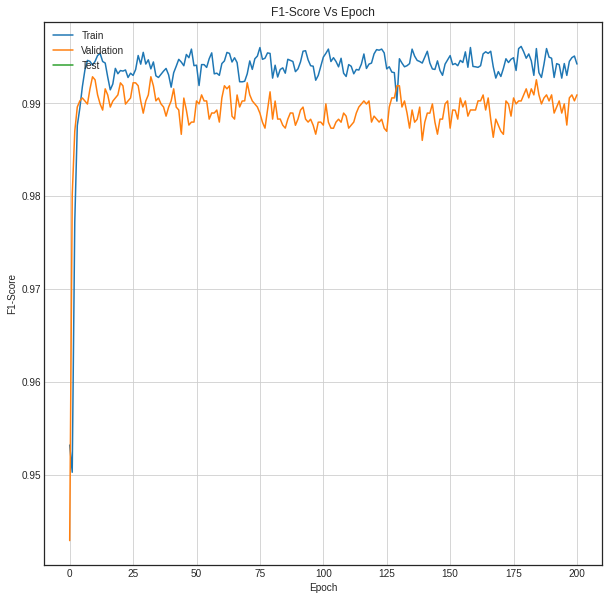

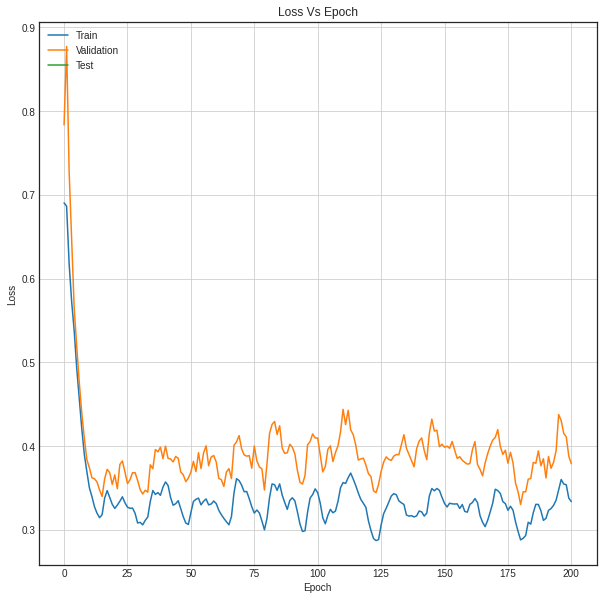

Baseline Error train: 0.05%
Baseline Error dev: 1.33%
Baseline Error test: 0.86%
Accuracy: 0.9995262908574135
F1 score: 0.9994660651717956
Recall: 0.9995262908574135
Precision: 0.9995276959829411

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      1.00      1.00       485
           3       1.00      1.00      1.00        41
           4       1.00      1.00      1.00       194
           8       1.00      0.33      0.50         3
           9       1.00      1.00      1.00       132
          12       1.00      1.00      1.00       793
          13       1.00      1.00      1.00       723
          14       1.00      1.00      1.00       948
          16       1.00      0.96      0.98        23
          17       1.00      1.00      1.00       616
          18       1.00      1.00      1.00      1790
          19       1.00      1.00      1.00       737
          20       1.0

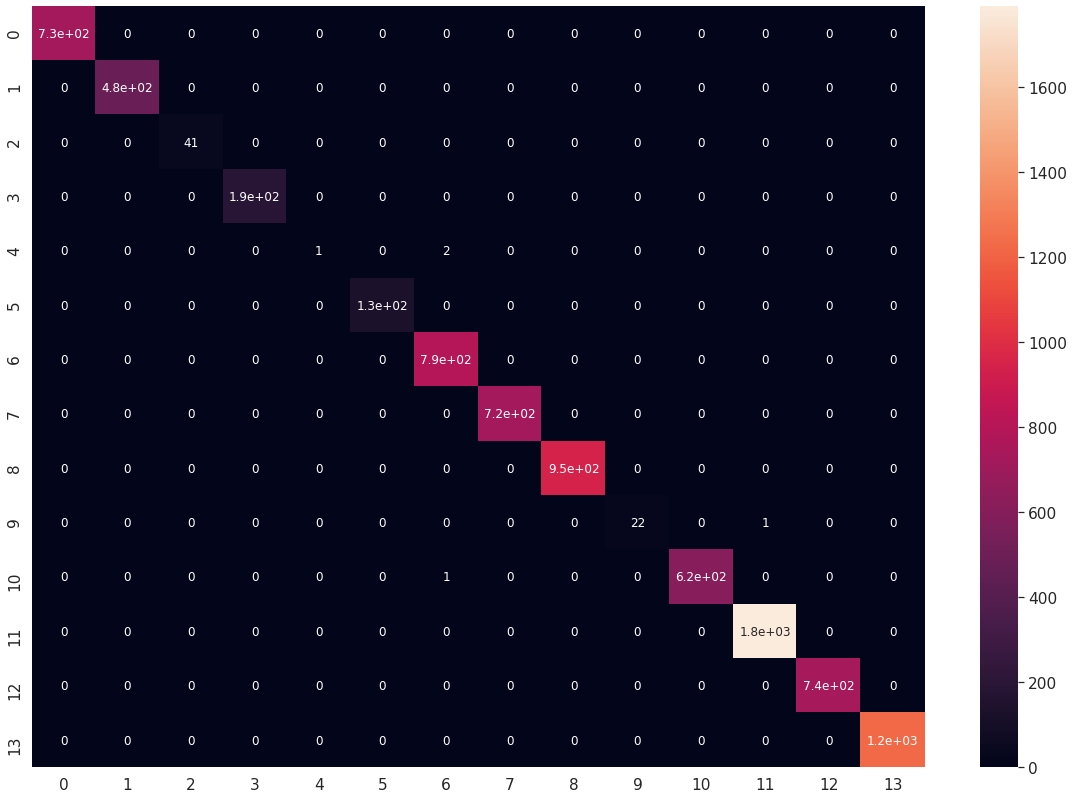

Accuracy: 0.9867424242424242
F1 score: 0.9867431556674475
Recall: 0.9867424242424242
Precision: 0.9869365619426728

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98        88
           1       1.00      0.95      0.98        63
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        24
           9       0.89      1.00      0.94         8
          12       0.98      0.97      0.98       105
          13       0.99      0.99      0.99        86
          14       0.98      0.98      0.98       131
          16       1.00      1.00      1.00         1
          17       1.00      0.99      0.99        71
          18       1.00      0.99      0.99       219
          19       0.99      1.00      0.99        99
          20       0.97      1.00      0.99       155

    accuracy                           0.99      1056
   macro avg       0.98      0.99      0.99     

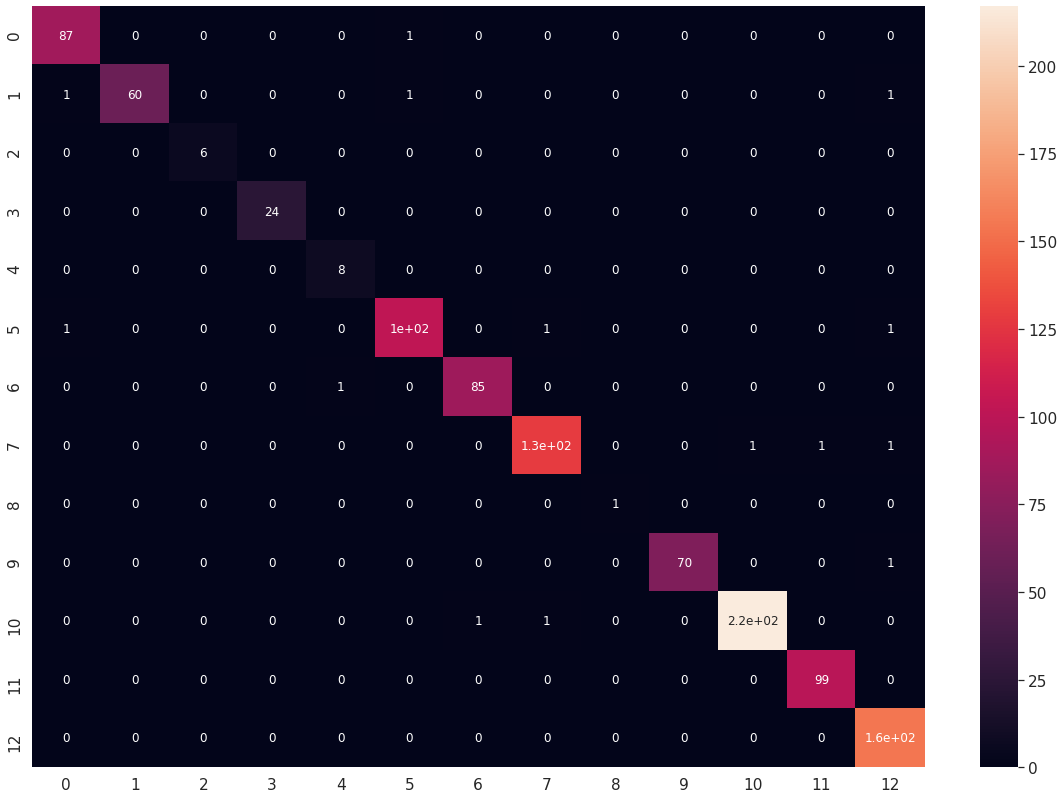

Accuracy: 0.990530303030303
F1 score: 0.9902446464418698
Recall: 0.990530303030303
Precision: 0.9906958983045939

 clasification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        88
           1       1.00      0.99      0.99        77
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        24
          12       0.99      0.98      0.98        92
          13       1.00      1.00      1.00        96
          14       1.00      0.99      1.00       112
          16       1.00      0.50      0.67         4
          17       1.00      0.99      0.99        80
          18       0.98      1.00      0.99       226
          19       1.00      0.99      0.99        86
          20       0.99      0.99      0.99       146

    accuracy                           0.99      1056
   macro avg       0.99      0.96      0.97      1

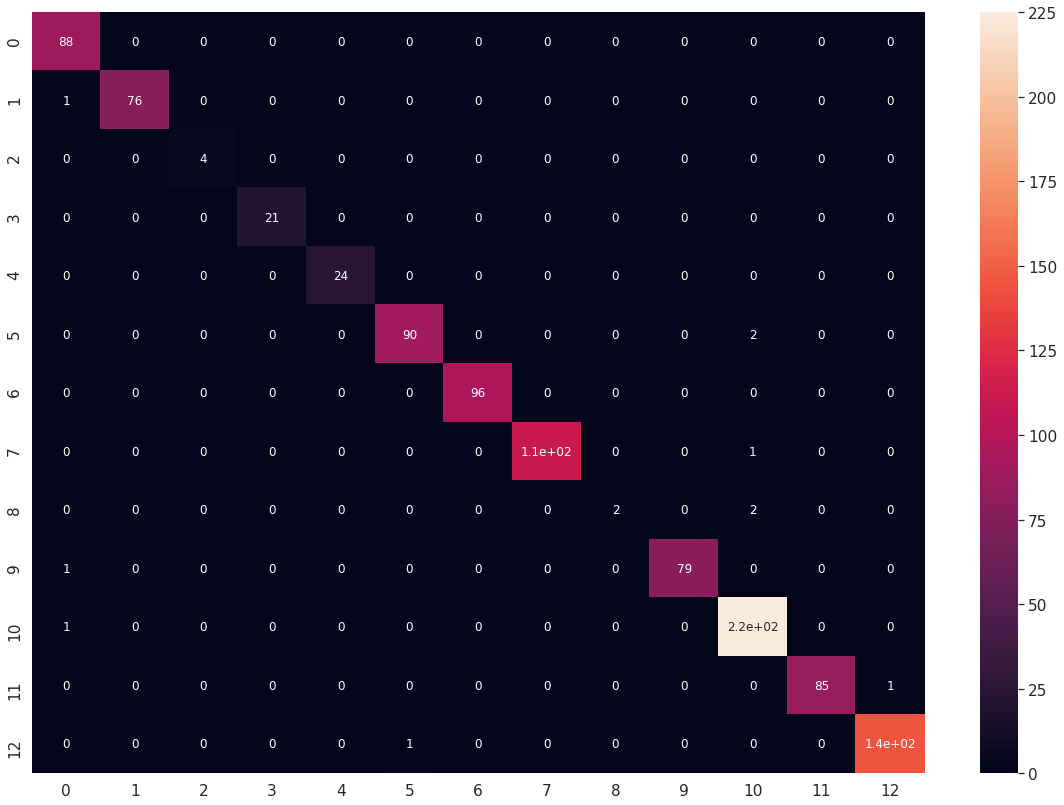

In [18]:
#graph the results
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

model = keras.models.load_model('logs/Coffee_2021-04-21_12-17-45/saved-model-200-0.9909.hdf5', custom_objects={'f1_m':f1_m})

scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

# making predictions

In [19]:
# generalization test
# load humblotiana data (k-mers)
filename = "/home/bioml/Projects/PhD/InpactorDB/version_final/genomes_for_test/GCF_003935025.1_Abrus_2018_genomic.fna.mod.LTR.intact.fa_final.kmers"
gen_data = pd.read_csv(filename)
label_vectors_gen = gen_data['Label'].values
feature_vectors_gen = gen_data.drop(['Label'], axis=1).values
#scaler = load(installation_path+'/home/bioml/Projects/PhD/OE3/std_scaler_coffee.bin')
feature_vectors_scaler = scaler.transform(feature_vectors_gen)
#pca = load(installation_path+'/home/bioml/Projects/PhD/OE2/std_pca_coffee.bin')
X_gen_pca_scaling = pca.transform(feature_vectors_scaler)

In [20]:
predictions = model.predict(X_gen_pca_scaling)

metrics(label_vectors_gen, [argmax(x) for x in predictions])

Accuracy: 0.4853195164075993
F1 score: 0.550014050165789
Recall: 0.4853195164075993
Precision: 0.7726659025759872

 clasification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.45      0.54        64
           4       1.00      1.00      1.00         5
           8       0.00      0.00      0.00         3
           9       0.74      0.52      0.61        60
          12       0.82      0.56      0.66        99
          13       0.00      0.00      0.00         0
          14       0.82      1.00      0.90        14
          17       0.58      0.58      0.58       107
          18       0.00      0.00      0.00        23
          19       1.00      0.18      0.31       143
          20       0.94      0.97      0.95        61

    accuracy                           0.49       579
   macro avg       0.55      0.44      0.46       579
weighted avg       0.77      0.49      0.55      

/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf114/li

ValueError: Shape of passed values is (12, 12), indices imply (10, 10)